# Fire Progressions

`wxee` is designed for processing weather data, but it can also be useful for remote sensing data. In this example, we'll look at how `wxee` can work with data from the GOES-16 and MODIS to visualize fire progressions over time.

## Setup

In [ ]:
!pip install wxee

In [1]:
import ee
import wxee

ee.Authenticate()
wxee.Initialize()

## Daily Progressions from MODIS
One of the products captured by the MODIS sensor is fire hotspot detections. We'll use `wxee` to load daily hotspots for the 2021 Caldor fire in California and visualize them by the time of burning.

### Downloading MODIS Data to xarray

To start with, we'll load 14 days of MODIS data as a `TimeSeries`.

In [2]:
modis = wxee.TimeSeries("MODIS/006/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")

modis.describe()

MODIS/006/MOD14A1
	Images: 21
	Start date: 2021-08-15 00:00:00 UTC
	End date: 2021-09-04 00:00:00 UTC
	Mean interval: 1.00 days


The `FireMask` band contains codes indicating the confidence of fire detections. First, we'll use `map` to turn those codes into binary images of fire presence, copying properties over so we don't lose any time information.

In [3]:
fire_masks = modis.map(lambda img: img.eq(9).copyProperties(img, img.propertyNames()))

Now we'll specify a bounding box around the Caldor fire and download the `TimeSeries` to an `xarray.Dataset`.

In [4]:
region = ee.Geometry.Polygon(
        [[[-120.70580745719522, 38.90798203224902],
          [-120.70580745719522, 38.51793451346024],
          [-119.90014827750772, 38.51793451346024],
          [-119.90014827750772, 38.90798203224902]]]
)

ds = fire_masks.wx.to_xarray(scale=1000, region=region, crs="EPSG:26910")

Requesting:   0%|          | 0/21 [00:00<?, ?it/s]

Downloading:   0%|          | 0/21 [00:00<?, ?it/s]

### Visualizing the Progression

The result will be 14 binary fire masks. Let's take a look.

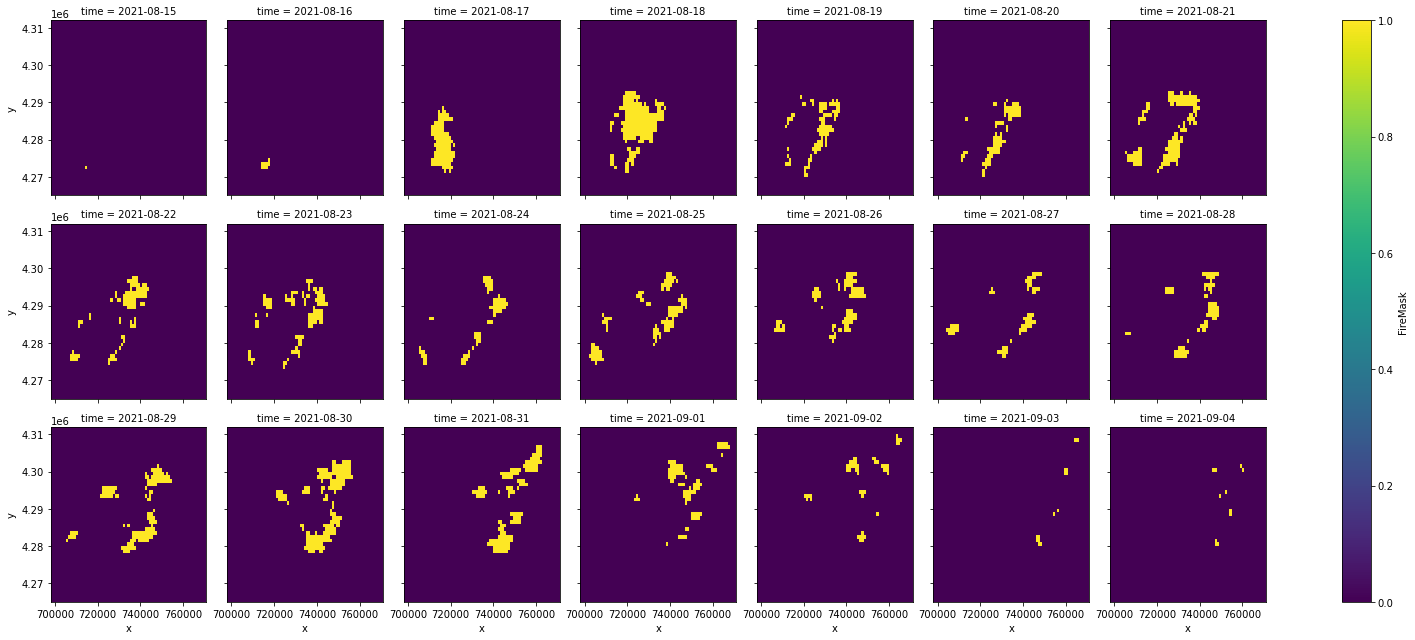

In [5]:
ds.FireMask.plot(col="time", col_wrap=7)

That shows us how the fire grew over time, but maybe we want a single summary image describing that progression. Let's calculate the first day that a given pixel burned. Rather than storing specific times, we'll represent them as time elapsed since the beginning of the time series.

First, get the start time of the time series and calculate the number of hours elapsed between each time step and the start time.

In [6]:
start = ds.time.min()
delta_days = (ds.time - start).dt.days

Now, we'll multiply the time delta by the fire mask. Because non-fire pixels have a value of 0, this will give us a 3D array with elapsed days since start for each hotspot pixel and values of 0 for all other pixels. We cast from a `timedelta` to an `int` to allow plotting.

In [7]:
delta_days_fire = (ds.FireMask * delta_days).astype(int)

Finally, we can mask non-hotspot pixels (values of 0) and take the minimum over time to get the first time, in days elapsed since start, that each pixel burned.

In [8]:
first_burned = delta_days_fire.where(delta_days_fire != 0).min("time")

And of course, plot it!

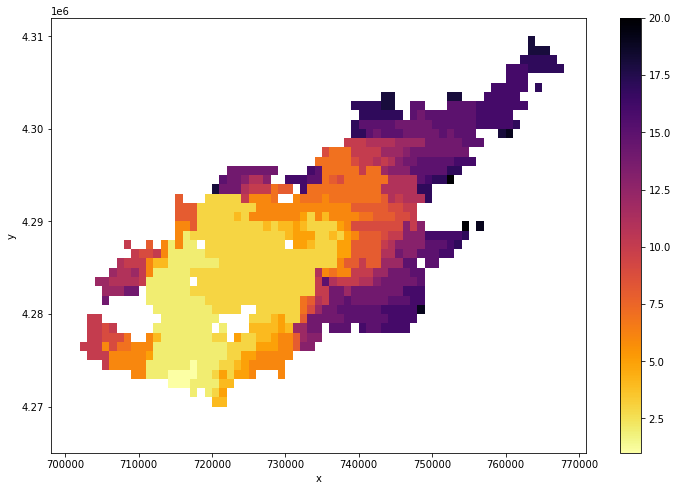

In [9]:
first_burned.plot(size=8, cmap="inferno_r")

## Hourly Progressions from GOES-16

Unlike MODIS which captures daily hotspots, GOES-16 captures hotspots every 5 minutes! This is great for tracking fast-moving fires, but it also means we have to deal with a lot more data. We can use `wxee` and the `aggregate_time` method to aggregate those 5-minute hotspots to hourly hotspots.

### Downloading GOES-16 data to xarray

First, we'll load GOES-16 data over a time window that experienced explosive fire growth in the Western Cascades of Oregon in 2020.

In [10]:
ts = wxee.TimeSeries("NOAA/GOES/16/FDCC").select("Mask").filterDate("2020-09-08", "2020-09-09")
ts.describe("minute")

NOAA/GOES/16/FDCC
	Images: 288
	Start date: 2020-09-08 00:01:16 UTC
	End date: 2020-09-08 23:56:16 UTC
	Mean interval: 5.00 minutes


Like with MODIS, we'll have to convert mask codes to a binary fire mask. For GOES, we'll use the codes 10, 11, 30, and 31.

In [11]:
def fire_mask(img):
    mask = ee.Image(0).rename("fire")
    mask = (mask
        .where(img.eq(10), 1)
        .where(img.eq(11), 1)
        .where(img.eq(30), 1)
        .where(img.eq(31), 1)
    )
    # Copy the properties from the original images to avoid losing time data.
    return mask.copyProperties(img, img.propertyNames())

# Convert each mask class image into a binary fire presence mask
fire_masks = ts.map(lambda img: fire_mask(img))

Now we can aggregate the 288 5-minute masks to 24 hourly masks. We'll use a max reducer, meaning that an hourly hotspot was detected at least once within the hour.

In [12]:
hourly_fire = fire_masks.aggregate_time("hour", reducer=ee.Reducer.max())
hourly_fire.describe("minute")

NOAA/GOES/16/FDCC
	Images: 24
	Start date: 2020-09-08 00:01:16 UTC
	End date: 2020-09-08 23:01:16 UTC
	Mean interval: 60.00 minutes


Select a region around the largest 2020 fire, Beachie Creek.

In [13]:
geom = ee.Geometry.Polygon(
    [[[-122.77807114256022, 45.370803623985665],
      [-122.77807114256022, 44.519360582318896],
      [-121.46520493162272, 44.519360582318896],
      [-121.46520493162272, 45.370803623985665]]]
)

And download the data to an `xarray.Dataset`.

In [14]:
ds = hourly_fire.wx.to_xarray(region=geom, scale=2_000, crs="EPSG:26910")

Requesting:   0%|          | 0/24 [00:00<?, ?it/s]

Downloading:   0%|          | 0/24 [00:00<?, ?it/s]

### Visualizing the Progression

Like before, we'll convert our time series of fire masks into a single image showing when each area burned in time elapsed.

In [15]:
start = ds.time.min()
# Convert milliseconds to hours
delta_hours = (ds.time - start) / 3_600_000_000_000

delta_hours_fire = (ds.fire * delta_hours).astype(int)

first_burned = delta_hours_fire.where(delta_hours_fire != 0).min("time")

And plot it!

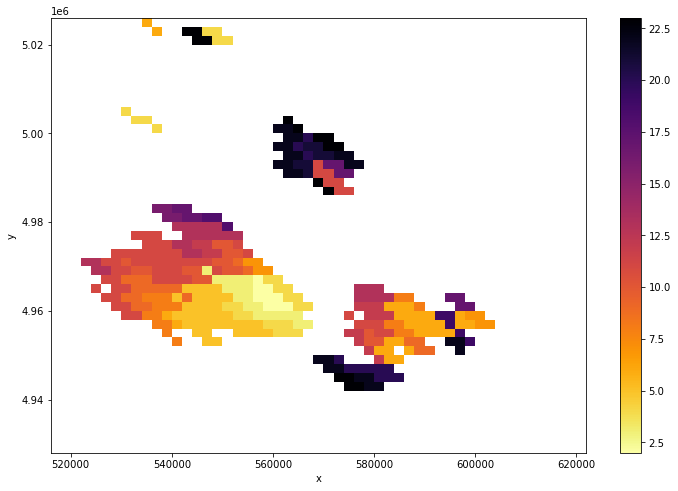

In [16]:
first_burned.plot(size=8, cmap="inferno_r")